## TMBD Movie Recommendation System 

Recommendation Systems are a type of information filtering systems as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user. companies like Netflix and Spotify depend highly on the effectiveness of their recommendation engines for their business and sucees.

In [1]:
import numpy as np ## for linear algebra
import pandas as pd  ## data processing
import json
import seaborn as sns
import time
# for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import display
# setting up the chart size and background
plt.rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
import base64
import io
import re
# import tensorflow as tf
# import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
# from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


ModuleNotFoundError: No module named 'tensorflow'

## Upload the dataset 

In [ ]:
movies = pd.read_csv('tmdb_5000_movies.csv')

credits = pd.read_csv('tmdb_5000_credits.csv')

* We will first look out for a identically same column and the shape of both data to merge.

In [ ]:
# A glimpse of the movie dataset
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,18000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",NaN,43434,"[{""id"": 1419, ""name"": ""gun""}, {""id"": 7336, ""na...",en,Carlos,"The story of Venezuelan revolutionary, Ilich R...",1.138383,"[{""name"": ""Egoli Tossell Film AG"", ""id"": 2254}...","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso...",2010-05-19,871279,338.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,The man who hijacked the world,Carlos,6.7,50


In [ ]:
# A glimpse of the credits dataset
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


**The row of documents should match in order to merge them**

In [ ]:
print(credits.shape)
print(movies.shape)

(4803, 4)
(4803, 20)


##  Merge two csv files 

In [ ]:
## We will combine movies and credits dataset using title column 
dataframe = movies.merge(credits, on="title")

#credits = credits.rename(index=str, columns={"movie_id": "id"}
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

In [ ]:
## We create the new dataframe with the significant columns to use in our recommendation system.
CV_dataframe = dataframe[['movie_id','title','genres','keywords','overview']]
CV_dataframe.dropna(inplace=True)
CV_dataframe.columns

C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\4264826921.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CV_dataframe.dropna(inplace=True)


Index(['movie_id', 'title', 'genres', 'keywords', 'overview'], dtype='object')

* **Data wrangling or cleaning is an essential step before starting off the recommendation system.
In this sense:** 
   *  Remove the Nan values
   *  Drop unneccessary columns

In [ ]:
dataframe.isnull().sum()

budget                     0
genres                     0
homepage                3096
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                       0
crew                       0
dtype: int64

In [ ]:
# Change release_date column type to datetime
dataframe.release_date = pd.to_datetime(dataframe.release_date) 
# Add new column "month"  and "weekday"
dataframe['year'] = pd.DatetimeIndex(dataframe['release_date']).year
dataframe["month"] = dataframe.release_date.dt.month_name()
dataframe['weekday'] = dataframe['release_date'].dt.day_name()

As indicated above, two columns have the Nan value. 
We will drop the unuseful columns from our dataset.

In [ ]:
dataframe = dataframe.drop(columns = ['homepage', 'movie_id','original_language', 'status','original_title','tagline'],axis=0)

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                4809 non-null   int64         
 1   genres                4809 non-null   object        
 2   id                    4809 non-null   int64         
 3   keywords              4809 non-null   object        
 4   overview              4806 non-null   object        
 5   popularity            4809 non-null   float64       
 6   production_companies  4809 non-null   object        
 7   production_countries  4809 non-null   object        
 8   release_date          4808 non-null   datetime64[ns]
 9   revenue               4809 non-null   int64         
 10  runtime               4807 non-null   float64       
 11  spoken_languages      4809 non-null   object        
 12  title                 4809 non-null   object        
 13  vote_average      

In [ ]:
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

dataframe.head()

,budget,genres,id,keywords,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,cast,crew,year,month,weekday
0,18000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",43434,"[{""id"": 1419, ""name"": ""gun""}, {""id"": 7336, ""na...","The story of Venezuelan revolutionary, Ilich R...",1.138383,"[{""name"": ""Egoli Tossell Film AG"", ""id"": 2254}...","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso...",2010-05-19,871279,338.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Carlos,6.7,50,"[{""cast_id"": 4, ""character"": ""Ilich Ram\u00edr...","[{""credit_id"": ""57352b61c3a3680253000870"", ""de...",2010.0,May,Wednesday
1,0,"[{""id"": 18, ""name"": ""Drama""}]",112430,"[{""id"": 11162, ""name"": ""miniseries""}]",Real-life figures from the Cold War era mix wi...,1.485324,[],[],2007-08-05,0,276.0,[],The Company,7.0,12,"[{""cast_id"": 1, ""character"": ""Jack McAuliffe"",...","[{""credit_id"": ""5322a7959251411f770044a3"", ""de...",2007.0,August,Sunday
2,0,"[{""id"": 10752, ""name"": ""War""}, {""id"": 18, ""nam...",10655,"[{""id"": 393, ""name"": ""civil war""}, {""id"": 4097...",Summer 1863. The Confederacy pushes north into...,5.529035,"[{""name"": ""TriStar Television"", ""id"": 8609}, {...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1993-10-08,25000000,254.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Gettysburg,6.6,90,"[{""cast_id"": 1, ""character"": ""Col. Joshua Cham...","[{""credit_id"": ""52fe439d9251416c750173fd"", ""de...",1993.0,October,Friday
3,31115000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 36, ""name...",8095,"[{""id"": 5049, ""name"": ""ancient rome""}, {""id"": ...",Historical epic. The triumphs and tragedy of t...,13.244365,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1963-06-12,71000000,248.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Cleopatra,6.7,146,"[{""cast_id"": 2, ""character"": ""Cleopatra"", ""cre...","[{""credit_id"": ""54afb978c3a3683fba003e96"", ""de...",1963.0,June,Wednesday
4,0,"[{""id"": 18, ""name"": ""Drama""}]",10549,"[{""id"": 456, ""name"": ""mother""}, {""id"": 497, ""n...","Hamlet, Prince of Denmark, returns home to fin...",9.814785,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1996-12-25,0,242.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Hamlet,7.3,117,"[{""cast_id"": 1, ""character"": ""Prince Hamlet"", ...","[{""credit_id"": ""52fe43869251416c75013ba5"", ""de...",1996.0,December,Wednesday


* Five columns are in the JSON format (genres, keywords, production_companies, production_countries, and spoken_languages).  Similarly in the other CSV file, cast and crew are in the JSON format.
We will convert them into strings and later convert them into lists for easier interpretation.

* Content Based Filtering
In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

## Explanatory Data Analysis

EDA is applied to thoroughfully investigate the dataframe, find the useful correlations and summarize the key insights about the movie industry.

C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\24415806.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append(rows)
C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\24415806.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append(rows)
C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\24415806.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append(rows)
C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\24415806.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append(rows)
C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\24415806.py:15: FutureWarning: The fra

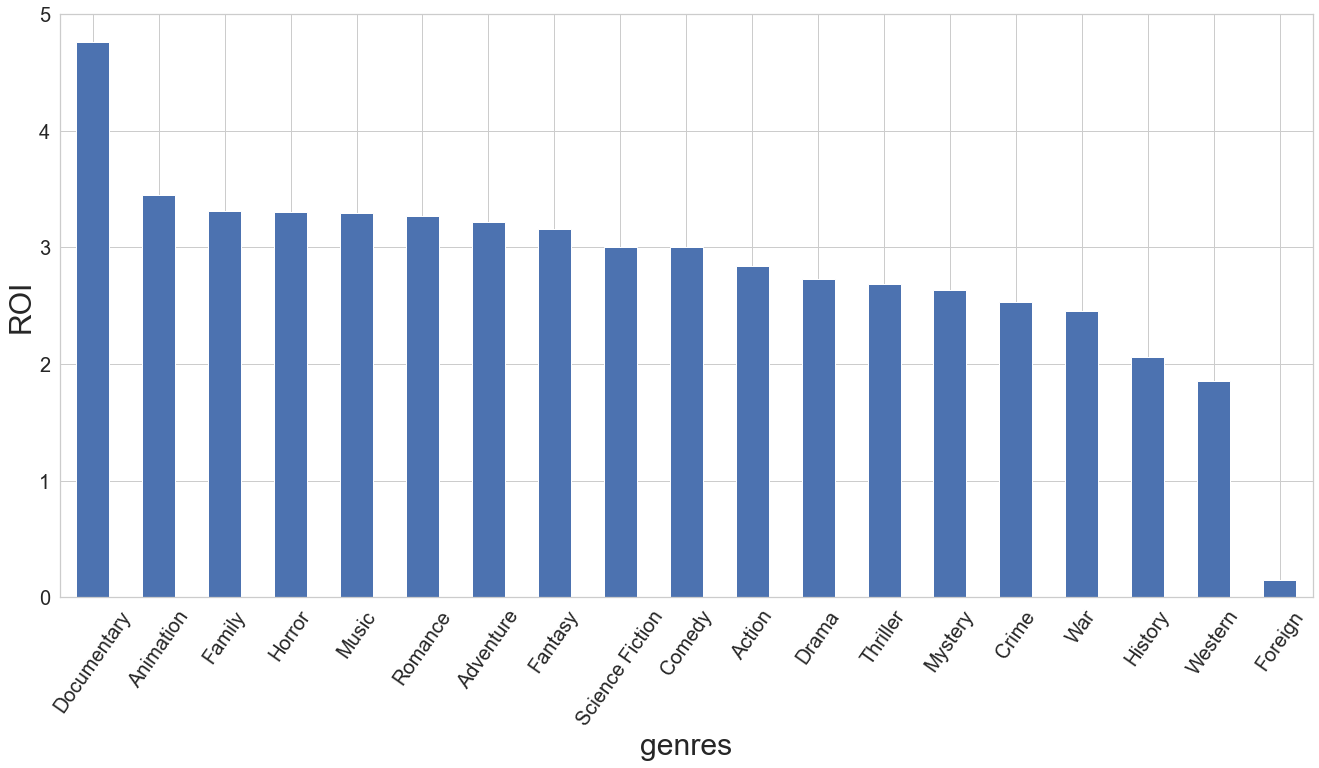

In [ ]:
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d
def expand_multi_feature(dataframe,column,index="id"):
    groups=group_indices(dataframe[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=dataframe.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result


def multi_groupby(dataframe,column,index="id"):
    return expand_multi_feature(dataframe,column,index).groupby(column)
# return on investment of each genres' movies
def plotby_portion(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    #sns.barplot(data=multi_groupby(dataframe,x,"name")[y].mean().transpose())
    group=multi_groupby(df.dropna(subset=y),x,"name")
    (group[y[0]].mean()/group[y[1]].mean()).sort_values(ascending=False).plot(kind="bar")
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel("ROI",fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()

saving =False
plotby_portion(dataframe,"genres",["revenue","budget"],filename="genres_ROI.png")

In [ ]:
dataframe['crew'] = dataframe['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
dataframe['crew'] = dataframe['crew'].apply(director)
dataframe.rename(columns={'crew':'director'},inplace=True)

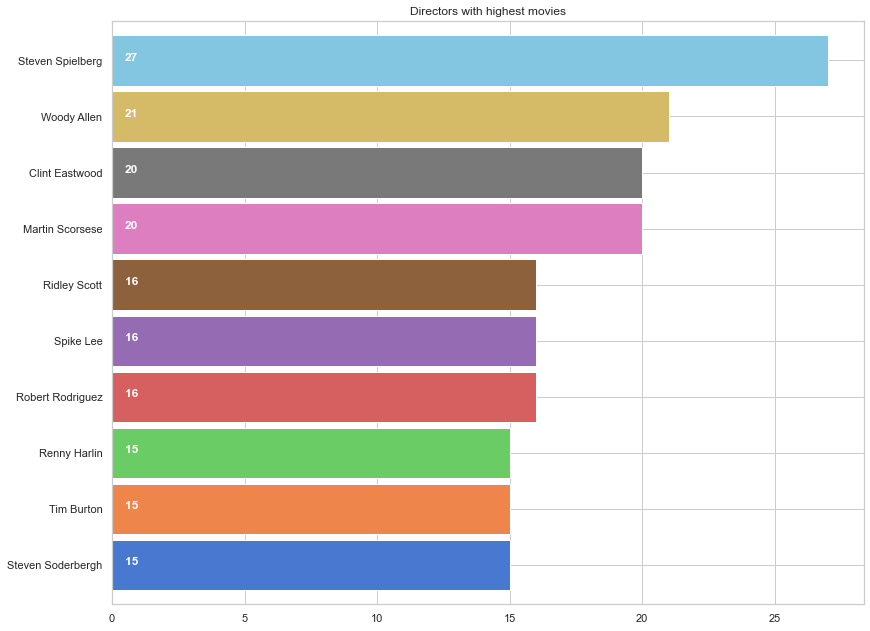

In [ ]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
dataframe['director'] = dataframe['director'].apply(xstr)

plt.subplots(figsize=(12,10))
ax = dataframe[dataframe['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(dataframe[dataframe['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

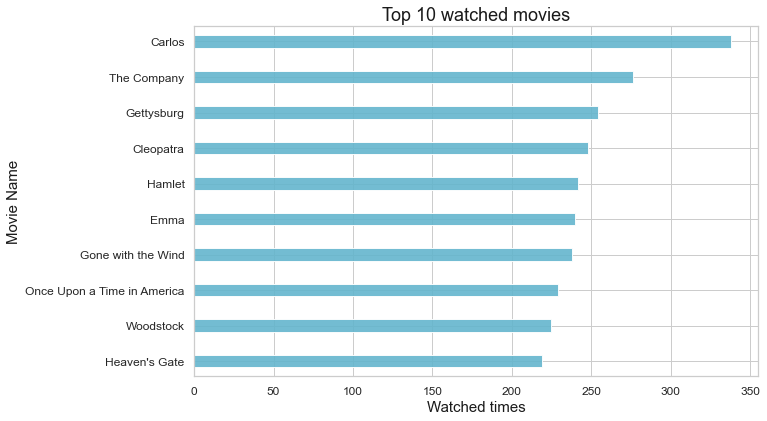

In [ ]:
top10 = dataframe.nlargest(10,"runtime")[["title","runtime"]]
top10.groupby("title")["runtime"].sum().sort_values().plot(kind="barh",
                                                                                 rot = 0,
                                                                                 width = 0.35,
                                                                                 color=["c"],
                                                                                 alpha = 0.9,
                                                                                 fontsize = 12,
                                                                                 figsize=(9,6),
                                                                                 )

plt.ylabel("Movie Name",fontsize=15, color="k")
plt.xlabel("Watched times",fontsize=15, color="k")
plt.title("Top 10 watched movies", fontsize=18, color="k");

Return on investment (ROI) is a performance measure used to evaluate the efficiency or profitability of an investment or compare the efficiency of a number of different investments. 
* **Documentaries are considered as a profitable investment.**

Does Budget and Revenue have an impact on Popularity of Movies ?

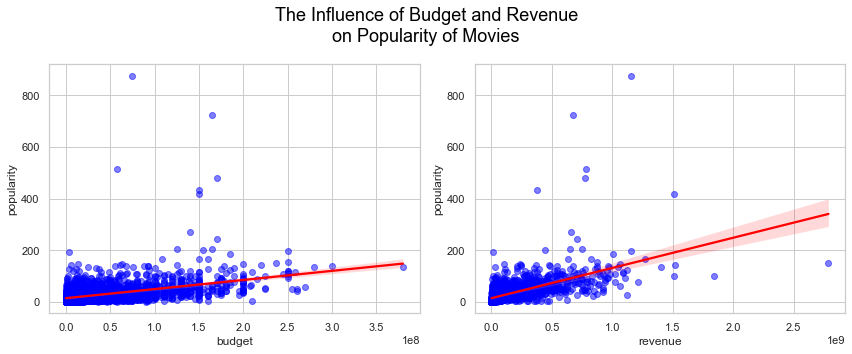

In [ ]:
bud_rev = dataframe[(dataframe['budget'] != 0) & (dataframe['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, color='black')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=bud_rev, x=col, y='popularity',
                scatter_kws={"color": "blue", "alpha": 0.5}, line_kws={"color": "red"}, ax=axes[i])

plt.tight_layout()

- Budget has no effect on the popularity. On the other hand, there is a relationship between revenue and popularity

**Analyze top 5 genres based on their runtime, popularity, budget and reveneu**

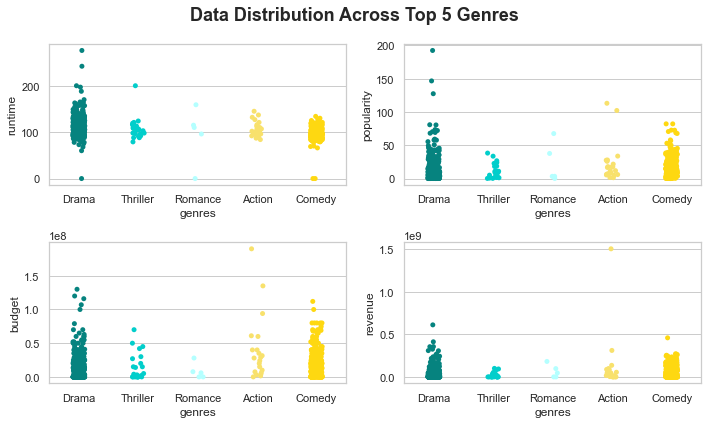

In [ ]:
from collections import Counter
dataframe['genres'] = dataframe['genres'].apply(get_text)

genres_list = []
for i in dataframe['genres']:
    genres_list.extend(i.split(', '))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = dataframe[dataframe['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600)
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()


**Movie Recommender System using Collaborative Filtering in Python**

In [ ]:
data_final= dataframe
data_final.head()

,budget,genres,id,keywords,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,cast,director,year,month,weekday
0,18000000,"Crime, Drama, Thriller, History",43434,"[{""id"": 1419, ""name"": ""gun""}, {""id"": 7336, ""na...","The story of Venezuelan revolutionary, Ilich R...",1.138383,"[{""name"": ""Egoli Tossell Film AG"", ""id"": 2254}...","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso...",2010-05-19,871279,338.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Carlos,6.7,50,"[{""cast_id"": 4, ""character"": ""Ilich Ram\u00edr...",Olivier Assayas,2010.0,May,Wednesday
1,0,Drama,112430,"[{""id"": 11162, ""name"": ""miniseries""}]",Real-life figures from the Cold War era mix wi...,1.485324,[],[],2007-08-05,0,276.0,[],The Company,7.0,12,"[{""cast_id"": 1, ""character"": ""Jack McAuliffe"",...",Mikael Salomon,2007.0,August,Sunday
2,0,"War, Drama, History",10655,"[{""id"": 393, ""name"": ""civil war""}, {""id"": 4097...",Summer 1863. The Confederacy pushes north into...,5.529035,"[{""name"": ""TriStar Television"", ""id"": 8609}, {...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1993-10-08,25000000,254.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Gettysburg,6.6,90,"[{""cast_id"": 1, ""character"": ""Col. Joshua Cham...",Ronald F. Maxwell,1993.0,October,Friday
3,31115000,"Drama, History, Romance",8095,"[{""id"": 5049, ""name"": ""ancient rome""}, {""id"": ...",Historical epic. The triumphs and tragedy of t...,13.244365,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1963-06-12,71000000,248.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Cleopatra,6.7,146,"[{""cast_id"": 2, ""character"": ""Cleopatra"", ""cre...",Joseph L. Mankiewicz,1963.0,June,Wednesday
4,0,Drama,10549,"[{""id"": 456, ""name"": ""mother""}, {""id"": 497, ""n...","Hamlet, Prince of Denmark, returns home to fin...",9.814785,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1996-12-25,0,242.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Hamlet,7.3,117,"[{""cast_id"": 1, ""character"": ""Prince Hamlet"", ...",Kenneth Branagh,1996.0,December,Wednesday


### Weighted Rating 

IMDB (please remember that we are working with TMDB data after the takedown request by IMDB) does not use the plain movie vote_averages as the score to for instance compose its Top250. Instead,it uses a formula that also takes the number of votes into account:

- R = average rating for the movie as a number from 1 to 10 (vote_average)
- v = number of votes for the movie (vote_count)
- q = the mean vote across the whole report

In [ ]:
avg = dataframe["vote_average"].mean()
q = dataframe["vote_count"].quantile(0.9)
def weighted_rating(x, q=q, avg=avg):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+q) * R) + (q/(q+v) * avg)
# apply for qualfied movies
dataframe["score"] = dataframe.apply(weighted_rating, axis=1)
# Sort movies based on score calculated above
dataframe = dataframe.sort_values('score', ascending=False)

# Print the top 10 movies
listed = dataframe[['title', 'vote_count', 'vote_average', 'score', "popularity"]].head(10)

- Top 10 Movies Based on the Weighted Rating

C:\Users\fbayk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Movie Vs Score')

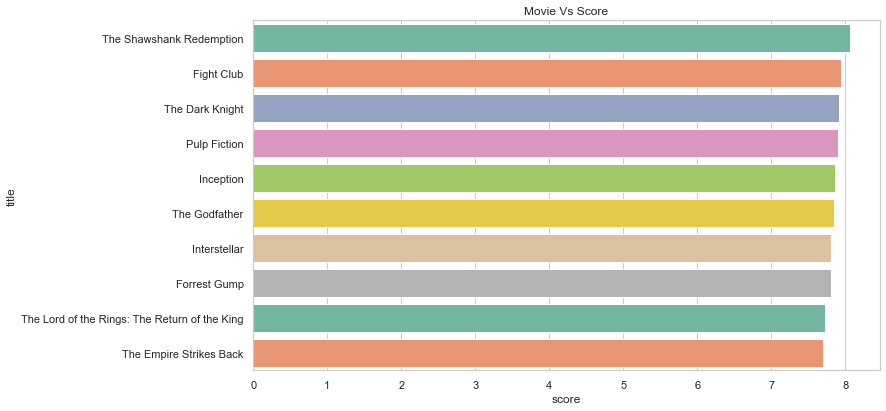

In [ ]:
plt.subplots(figsize=(10,6))
sns.barplot(listed["score"], listed["title"], palette="Set2")
plt.title("Movie Vs Score")

## Insights about the movie release date

C:\Users\fbayk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Number of releases')

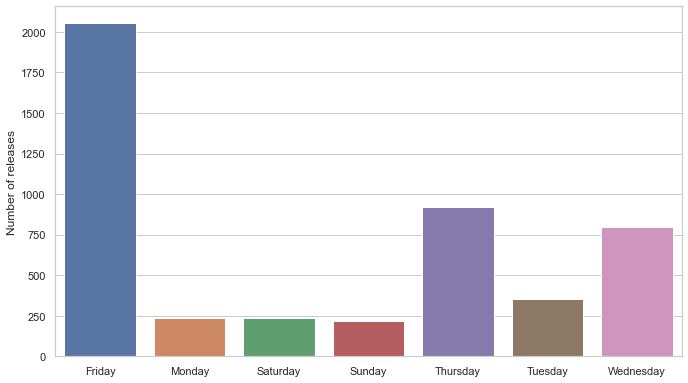

In [ ]:
weekday = dataframe['weekday'].value_counts().sort_index()
plt.figure(figsize=(10,6))
sns.barplot(weekday.index,weekday)
plt.ylabel('Number of releases')

Most of the movies prefer to be released on Friday.

In [ ]:
# check the year which released highest number of movies using groupby
high_month = dataframe.groupby("month")["id"].count().sort_values(ascending=False)
high_month

month
September    588
October      475
December     456
August       413
June         390
January      382
March        373
July         365
May          364
April        350
February     326
November     326
Name: id, dtype: int64

The new movies are mostly released in the autumn months.

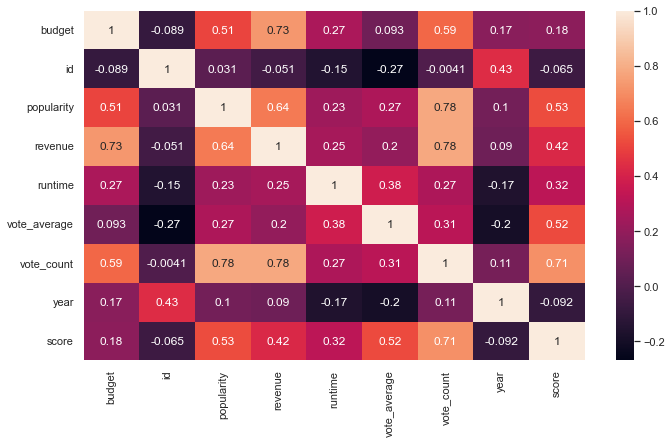

In [ ]:
#cheking the correlations
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(dataframe.corr(), annot=True, ax=ax);

In [ ]:
dataframe.head()

,budget,genres,id,keywords,overview,popularity,production_companies,production_countries,release_date,revenue,...,spoken_languages,title,vote_average,vote_count,cast,director,year,month,weekday,score
261,25000000,"Drama, Crime",278,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",Framed in the 1940s for the double murder of h...,136.747729,"[{""name"": ""Castle Rock Entertainment"", ""id"": 97}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-23,28341469,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Shawshank Redemption,8.5,8205,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...",Frank Darabont,1994.0,September,Friday,8.058576
306,63000000,Drama,550,"[{""id"": 825, ""name"": ""support group""}, {""id"": ...",A ticking-time-bomb insomniac and a slippery s...,146.757391,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",1999-10-15,100853753,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Fight Club,8.3,9413,"[{""cast_id"": 4, ""character"": ""The Narrator"", ""...",David Fincher,1999.0,October,Friday,7.938689
159,185000000,"Drama, Action, Crime, Thriller",155,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Batman raises the stakes in his war on crime. ...,187.322927,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2008-07-16,1004558444,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",The Dark Knight,8.2,12002,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...",Christopher Nolan,2008.0,July,Wednesday,7.919564
150,8000000,"Thriller, Crime",680,"[{""id"": 396, ""name"": ""transporter""}, {""id"": 14...","A burger-loving hit man, his philosophical par...",121.463076,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-10-08,213928762,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Pulp Fiction,8.3,8428,"[{""cast_id"": 2, ""character"": ""Vincent Vega"", ""...",Quentin Tarantino,1994.0,October,Saturday,7.904036
189,160000000,"Action, Thriller, Science Fiction, Mystery, Ad...",27205,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...","Cobb, a skilled thief who commits corporate es...",167.583710,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2010-07-14,825532764,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Inception,8.1,13752,"[{""cast_id"": 1, ""character"": ""Dom Cobb"", ""cred...",Christopher Nolan,2010.0,July,Wednesday,7.862848


# Content Based Recommendation

###  TFidf Vectorizer

Creating Content Based Recommendations based on movie plot summary in "overview" column
Recommend movies that have similar plot summaries
For each and every movie - we create a vector of matrix
Applying a recommendation system => Usually based on pair-wise similarity
To find this similarity => we need to represent each and every movie summary as a vector
We will used NLP Concept of TFidf Vectorizer which will help us creating a document matrix.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(
    min_df = 3,
    max_features = None,
    strip_accents = "unicode",
    analyzer = "word",
    token_pattern = r'\w{1,}',
    ngram_range = (1, 3),         # Taking combinations of 1-3 different kind of words
    stop_words = "english"        # Remove the unnecessary stopword characters
)

dataframe['overview'] = dataframe['overview'].fillna('')   # Removing NaN values

tfv_matrix = tfv.fit_transform(dataframe['overview'])   # => Sparse Matrix(vectors) => most of the values in matrix = 0
tfv_matrix

<4809x10444 sparse matrix of type '<class 'numpy.float64'>'
	with 127520 stored elements in Compressed Sparse Row format>

In [ ]:
dataframe.budget = dataframe.budget.astype(int)
dataframe.revenue = dataframe.revenue.astype(int)
dataframe["profit"] = dataframe.revenue - dataframe.budget

In [ ]:
dataframe['director'].head()

261       Frank Darabont
306        David Fincher
159    Christopher Nolan
150    Quentin Tarantino
189    Christopher Nolan
Name: director, dtype: object

In [ ]:
from sklearn.metrics.pairwise import sigmoid_kernel
# Sigmoid => Responsible for transforming input between 0 to 1
# Passing the summary vectors in the sigmoid function => Will get values between 0 and 1

sig = sigmoid_kernel(tfv_matrix, tfv_matrix)    # Combination of the same matrix
sig[0]
# Overview 1 related to overview 1, overview 1 related to overview 2, overview 1 related to overview 3, and so on

array([0.76163437, 0.76159448, 0.76159416, ..., 0.76159416, 0.76159443,
       0.7615953 ])

In [ ]:
# Mapping of Indices and Corresponding Movie Titles in the dataset
indices = pd.Series(dataframe.index, index=dataframe['title']).drop_duplicates()
indices

title
The Shawshank Redemption         261
Fight Club                       306
The Dark Knight                  159
Pulp Fiction                     150
Inception                        189
                                ... 
Dragonball Evolution            4436
Independence Day: Resurgence     994
The Boy Next Door               3906
Batman & Robin                   721
Fantastic Four                  2724
Length: 4809, dtype: int64

In [ ]:
# Sorting according to the scores in the list
sorted(list(enumerate(sig[indices['Carlos']])), key=lambda x: x[1], reverse=True)

[(0, 0.7616343650439805),
 (2945, 0.7616037755299634),
 (2226, 0.7616015743219369),
 (616, 0.7616007554032661),
 (3821, 0.7616000558444473),
 (1780, 0.761599997243209),
 (1528, 0.7615996794877128),
 (3143, 0.7615996029534822),
 (4142, 0.7615990580284551),
 (1109, 0.761598987343489),
 (220, 0.7615986613093518),
 (2376, 0.7615986395191466),
 (814, 0.761598447250619),
 (92, 0.7615982646203547),
 (1667, 0.7615982557502025),
 (3633, 0.761598218859038),
 (1995, 0.7615982153486214),
 (975, 0.7615982128560971),
 (2472, 0.7615981651917072),
 (4037, 0.7615981504108077),
 (2400, 0.7615980860918075),
 (4387, 0.7615978705840704),
 (40, 0.7615978385587772),
 (1654, 0.7615978235184596),
 (1570, 0.7615978070943517),
 (2091, 0.7615977679187713),
 (1908, 0.7615976957743855),
 (1397, 0.7615976849096631),
 (2670, 0.7615976395038471),
 (3701, 0.7615976299902302),
 (2336, 0.7615975503359458),
 (501, 0.7615973767275718),
 (1079, 0.7615973585431656),
 (4420, 0.7615973473853903),
 (3226, 0.7615973250012317),
 

In [ ]:
# Give movie title as input and based on the movie title we apply the object created in the sigmoid kernal
# Doing the same thing as above but putting it in the fuction
def give_recommendation(title, sig=sig):
    index = indices[title]   
    sig_scores = list(enumerate(sig[index]))   
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    
    # Getting Top 7 scores(index, scores)
    sig_scores = sig_scores[1:7]   
    movie_indices = [i[0] for i in sig_scores]
    return dataframe['title'].iloc[movie_indices]

In [ ]:
give_recommendation('Inception')

891     Ocean's Thirteen
1942           12 Rounds
534     Last Action Hero
2422           Unleashed
3084                  Go
722       Ocean's Twelve
Name: title, dtype: object

# Content Based Recommendation 

### Countvectorizer

When you pass the text data through the ‘count vectorizer’ function, it returns a matrix of the number count of each word.

In [ ]:
import ast
def convert(obj):
    List = []
    for i in ast.literal_eval(obj):
        List.append(i['name'])
    return List
CV_dataframe['genres'] = CV_dataframe['genres'].apply(convert)
CV_dataframe['keywords'] = CV_dataframe['keywords'].apply(convert)

In [ ]:
# overview is a column of string, so we'll covert it into list
CV_dataframe['overview'] = CV_dataframe['overview'].apply(lambda x:x.split())
CV_dataframe.head()

,movie_id,title,genres,keywords,overview
0,43434,Carlos,"[Crime, Drama, Thriller, History]","[gun, car bomb, miniseries, terrorism, opec, h...","[The, story, of, Venezuelan, revolutionary,, I..."
1,112430,The Company,[Drama],[miniseries],"[Real-life, figures, from, the, Cold, War, era..."
2,10655,Gettysburg,"[War, Drama, History]","[civil war, independence, troops, army, battle...","[Summer, 1863., The, Confederacy, pushes, nort..."
3,8095,Cleopatra,"[Drama, History, Romance]","[ancient rome, historical figure, cleopatra, j...","[Historical, epic., The, triumphs, and, traged..."
4,10549,Hamlet,[Drama],"[mother, shakespeare, denmark, loss of father,...","[Hamlet,, Prince, of, Denmark,, returns, home,..."


In [ ]:
# now we'll remove space
CV_dataframe['keywords'] = CV_dataframe['keywords'].apply(lambda x:[i.replace(' ', '') for i in x])
CV_dataframe['genres'] = CV_dataframe['genres'].apply(lambda x:[i.replace(' ', '') for i in x])
CV_dataframe.head()

,movie_id,title,genres,keywords,overview
0,43434,Carlos,"[Crime, Drama, Thriller, History]","[gun, carbomb, miniseries, terrorism, opec, ho...","[The, story, of, Venezuelan, revolutionary,, I..."
1,112430,The Company,[Drama],[miniseries],"[Real-life, figures, from, the, Cold, War, era..."
2,10655,Gettysburg,"[War, Drama, History]","[civilwar, independence, troops, army, battle,...","[Summer, 1863., The, Confederacy, pushes, nort..."
3,8095,Cleopatra,"[Drama, History, Romance]","[ancientrome, historicalfigure, cleopatra, jul...","[Historical, epic., The, triumphs, and, traged..."
4,10549,Hamlet,[Drama],"[mother, shakespeare, denmark, lossoffather, p...","[Hamlet,, Prince, of, Denmark,, returns, home,..."


In [ ]:
CV_dataframe['details'] =  CV_dataframe['keywords']+ CV_dataframe['genres'] + CV_dataframe['overview']
CV_dataframe

,movie_id,title,genres,keywords,overview,details
0,43434,Carlos,"[Crime, Drama, Thriller, History]","[gun, carbomb, miniseries, terrorism, opec, ho...","[The, story, of, Venezuelan, revolutionary,, I...","[gun, carbomb, miniseries, terrorism, opec, ho..."
1,112430,The Company,[Drama],[miniseries],"[Real-life, figures, from, the, Cold, War, era...","[miniseries, Drama, Real-life, figures, from, ..."
2,10655,Gettysburg,"[War, Drama, History]","[civilwar, independence, troops, army, battle,...","[Summer, 1863., The, Confederacy, pushes, nort...","[civilwar, independence, troops, army, battle,..."
3,8095,Cleopatra,"[Drama, History, Romance]","[ancientrome, historicalfigure, cleopatra, jul...","[Historical, epic., The, triumphs, and, traged...","[ancientrome, historicalfigure, cleopatra, jul..."
4,10549,Hamlet,[Drama],"[mother, shakespeare, denmark, lossoffather, p...","[Hamlet,, Prince, of, Denmark,, returns, home,...","[mother, shakespeare, denmark, lossoffather, p..."
...,...,...,...,...,...,...
4802,300327,Death Calls,[],[],"[An, action-packed, love, story, on, the, Mexi...","[An, action-packed, love, story, on, the, Mexi..."
4803,320435,UnDivided,[],[],"[UnDivided, documents, the, true, story, of, h...","[UnDivided, documents, the, true, story, of, h..."
4804,150211,The Frozen,"[Horror, Thriller]","[bickering, accident, denialofdeath]","[After, a, harrowing, snowmobile, accident,, a...","[bickering, accident, denialofdeath, Horror, T..."
4805,40963,Little Big Top,[Comedy],[independentfilm],"[An, aging, out, of, work, clown, returns, to,...","[independentfilm, Comedy, An, aging, out, of, ..."


In [ ]:
CV_final= CV_dataframe[['movie_id','title','details']]

In [ ]:
CV_final['details'] = CV_final['details'].apply(lambda x :" ".join(x))
CV_final['details'] = CV_final['details'].apply(lambda x: x.lower())
CV_final.head()

C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\3160893188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CV_final['details'] = CV_final['details'].apply(lambda x :" ".join(x))
C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\3160893188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CV_final['details'] = CV_final['details'].apply(lambda x: x.lower())


,movie_id,title,details
0,43434,Carlos,gun carbomb miniseries terrorism opec hostages...
1,112430,The Company,miniseries drama real-life figures from the co...
2,10655,Gettysburg,civilwar independence troops army battle union...
3,8095,Cleopatra,ancientrome historicalfigure cleopatra juliusc...
4,10549,Hamlet,mother shakespeare denmark lossoffather prince...


Countvectorizer is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis). 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 5000, stop_words = 'english')

In [ ]:
##this one gives the frequency of the feature names in rows
vectors = cv.fit_transform(CV_final['details']).toarray()

In [ ]:
## this gives us the columns. it is two dimensinal matrix which has numerical data-vectors below
cv.get_feature_names()

C:\Users\fbayk\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '007',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '150',
 '16',
 '17',
 '17th',
 '18',
 '18th',
 '18thcentury',
 '19',
 '1930s',
 '1940s',
 '1944',
 '1950',
 '1950s',
 '1955',
 '1959',
 '1960',
 '1960s',
 '1965',
 '1967',
 '1970s',
 '1971',
 '1972',
 '1973',
 '1974',
 '1976',
 '1980',
 '1980s',
 '1985',
 '1990s',
 '1999',
 '19th',
 '19thcentury',
 '20',
 '200',
 '2003',
 '2009',
 '20th',
 '21st',
 '23',
 '24',
 '25',
 '30',
 '300',
 '3d',
 '40',
 '50',
 '500',
 '60',
 '60s',
 '70',
 '70s',
 'aaron',
 'abandoned',
 'abducted',
 'abilities',
 'ability',
 'able',
 'aboard',
 'abuse',
 'abusive',
 'academic',
 'academy',
 'accept',
 'accepted',
 'accepts',
 'access',
 'accident',
 'accidental',
 'accidentally',
 'accompanied',
 'accomplish',
 'account',
 'accountant',
 'accused',
 'ace',
 'achieve',
 'act',
 'acting',
 'action',
 'actionhero',
 'actions',
 'activist',
 'activities',
 'activity',
 'actor',
 'actors',
 'actress',
 'acts',
 'actual',
 'actually',
 'adam',
 'a

We use ‘cosine_similarity’ to find the similarity. This is a dynamic way of finding the similarity that measures the cosine angle between two vectors in a multi-dimensional space.  In this way, the size of the documents does not matter.

In [ ]:
##‘similarity’ is a two-dimensional matrix and it’s a coefficient matrix.
similarity = cosine_similarity(vectors)
sorted(list(enumerate(similarity[0])),reverse =True , key = lambda x:x[1])[1:6]

[(1476, 0.34299717028501775),
 (834, 0.3042903097250923),
 (852, 0.2946278254943948),
 (2978, 0.27777777777777785),
 (624, 0.27216552697590873)]

In [ ]:
def recommend(movie):
    movie_index = CV_final[CV_final['title'] == movie].index[0]
    distance = similarity[movie_index]
    movie_r = sorted(list(enumerate(distance)), reverse=True, key = lambda x:x[1])[1:6]
    for i in movie_r:
        print(CV_final.iloc[i[0]].title)

In [ ]:
recommend('Inception')

Duplex
Timecop
The Helix... Loaded
Star Trek II: The Wrath of Khan
Chicago Overcoat


## Model Evaluation
In this section we are going to apply different regression models and evaluate their performances. Finally, select one that has the best accuracy over the others and submit to kaggle to view our ranking.

First we convert the revenue to log as explained in the data exploration part.

In [ ]:
dataframe = dataframe.drop(columns = ['release_date'],axis=0)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 261 to 2724
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int32  
 1   genres                4809 non-null   object 
 2   id                    4809 non-null   int64  
 3   keywords              4809 non-null   object 
 4   overview              4809 non-null   object 
 5   popularity            4809 non-null   float64
 6   production_companies  4809 non-null   object 
 7   production_countries  4809 non-null   object 
 8   revenue               4809 non-null   int32  
 9   runtime               4807 non-null   float64
 10  spoken_languages      4809 non-null   object 
 11  title                 4809 non-null   object 
 12  vote_average          4809 non-null   float64
 13  vote_count            4809 non-null   int64  
 14  cast                  4809 non-null   object 
 15  director           

In [ ]:
X_data=dataframe.dtypes[dataframe.dtypes!='object'].index
X_data=dataframe[X_data]
X_data.fillna(method='ffill',inplace=True)
features = X_data.drop('score',axis=1)
target = X_data.score
target = np.log1p(target)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.2,random_state=42)

C:\Users\fbayk\AppData\Local\Temp\ipykernel_22272\4235497348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data.fillna(method='ffill',inplace=True)


In [ ]:
from sklearn.metrics import r2_score,mean_squared_error
import math


def PrintAccuracy(model,X_test,y_test):
    prediction = model.predict(X_test)
    return model.score(X_test,y_test) 

def PrintMSE(model,X_test,y_test):
    prediction = model.predict(X_test)
    return mean_squared_error(y_test,prediction)

def PrintRMSE(model,X_test,y_test):
    prediction = model.predict(X_test)
    return math.sqrt(mean_squared_error(y_test, prediction))

def PrintR2(model,X_test,y_test):
    prediction = model.predict(X_test)
    return r2_score(y_test,prediction)

names = []
accuracy = []
MSE = []
RMSE = []
R2 = []

We will save all the models performance in this table.

## Train and Test Error

In [ ]:
X_Train=X_train.values
X_Train=np.asarray(X_Train)
X_Train

array([[ 4.40000000e+07,  5.50300000e+03,  5.48842970e+01, ...,
         1.22000000e+03,  1.99300000e+03,  3.24875760e+08],
       [ 1.40000000e+07,  2.83000000e+03,  1.48136140e+01, ...,
         1.80000000e+02,  2.00300000e+03, -1.40000000e+07],
       [ 0.00000000e+00,  2.00800000e+03,  3.86602600e+00, ...,
         2.90000000e+01,  2.00500000e+03,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  3.19069000e+05,  5.94580000e-01, ...,
         8.00000000e+00,  2.01500000e+03,  0.00000000e+00],
       [ 0.00000000e+00,  1.00710000e+04,  8.31215300e+00, ...,
         4.60000000e+01,  2.00700000e+03,  0.00000000e+00],
       [ 1.80000000e+07,  4.96000000e+02,  2.94877840e+01, ...,
         1.57900000e+03,  2.00600000e+03,  2.43572744e+08]])

In [ ]:
from sklearn.preprocessing import StandardScaler
# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
X_std

array([[ 1.50270994,  0.85669106, -0.36770073],
       [-0.65517718, -0.39770863, -1.31531461],
       [-0.68196542, -0.07763606, -0.65823219],
       ...,
       [-0.82586837, -2.07080823,  0.913666  ],
       [-0.67861313, -0.2816977 , -0.71613286],
       [ 0.73031442, -0.1929795 , -1.25176261]])

Text(0, 0.5, 'Cumulative explained variance')

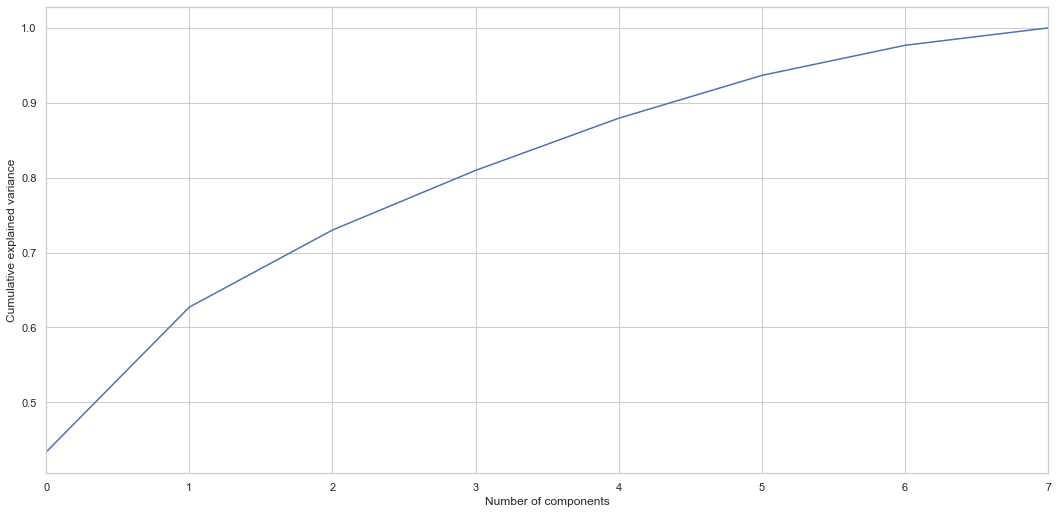

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Since 3 components can explain more than 80% of the variance, we choose the number of the components to be 3

In [ ]:
from sklearn.decomposition import PCA
sklearn_pca=PCA(n_components=3)
X_Train=sklearn_pca.fit_transform(X_std)
y_Train=list(y_train)

## Ridge Regression

In [ ]:
from sklearn import linear_model

model=linear_model.Ridge()
model.fit(X_train,y_train)
y_predict=model.predict(X_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_ridge=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_ridge)+" percent in Ridge Regression")

Y_test=model.predict(X_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_ridge=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_ridge)+" percent in Ridge Regression")

Train error = 0.661050859766634 percent in Ridge Regression
Test error = 0.7262774938719465 percent in Ridge Regression


In [ ]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
names.append("Ridge Regression")
R2.append(PrintR2(rr,X_test,y_test))
MSE.append(PrintMSE(rr,X_test,y_test))
RMSE.append(PrintRMSE(rr,X_test,y_test))
accuracy.append(PrintAccuracy(rr,X_test,y_test))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Ridge Regression')

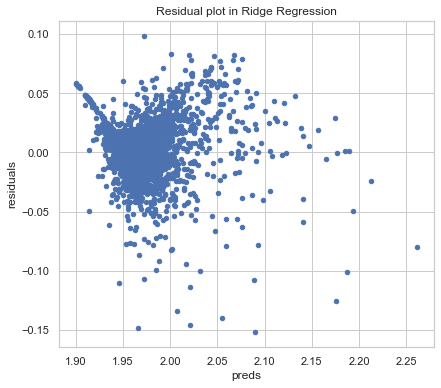

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Ridge Regression")

## Knn Algorithm

In [ ]:
from sklearn import neighbors
n_neighbors=3
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(X_train,y_train)
y1_knn=knn.predict(X_train)
y1_knn=list(y1_knn)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_knn[i]-y_Train[i])/y_Train[i])
train_error_knn=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_knn)+" percent"+" in Knn algorithm")

y2_knn=knn.predict(X_test)
y2_knn=list(y2_knn)
error=0
for i in range(len(y_test)):
    error+=(abs(y2_knn[i]-Y_test[i])/Y_test[i])
test_error_knn=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_knn)+" percent"+" in knn algorithm")

Train error = 0.7586253045124208 percent in Knn algorithm
Test error = 0.9737547480680133 percent in knn algorithm


In [ ]:
names.append("Knn Regression")
R2.append(PrintR2(knn,X_test,y_test))
MSE.append(PrintMSE(knn,X_test,y_test))
RMSE.append(PrintRMSE(knn,X_test,y_test))
accuracy.append(PrintAccuracy(knn,X_test,y_test))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Knn')

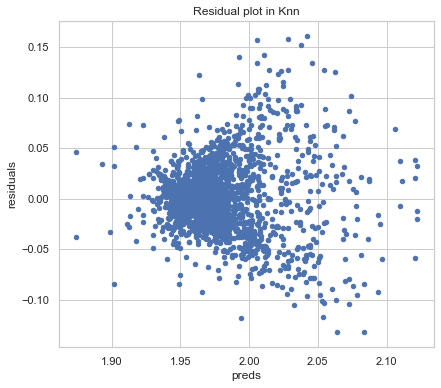

In [ ]:
mpl.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Knn")

## Lasso Regression 

In [ ]:
from sklearn.linear_model import Lasso

la = Lasso(alpha=0.1).fit(X_train,y_train)
y_predict=model.predict(X_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_lasso=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_lasso)+" percent in Lasso Regression")

Y_test=model.predict(X_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_lasso=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_lasso)+" percent in Lasso Regression")

Train error = 0.661050859766634 percent in Lasso Regression
Test error = 0.7262774938719465 percent in Lasso Regression


C:\Users\fbayk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 4.856e-04
  model = cd_fast.enet_coordinate_descent(


In [ ]:
names.append("Lasso Regression")
R2.append(PrintR2(la,X_test,y_test))
MSE.append(PrintMSE(la,X_test,y_test))
RMSE.append(PrintRMSE(la,X_test,y_test))
accuracy.append(PrintAccuracy(la,X_test,y_test))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Lasso')

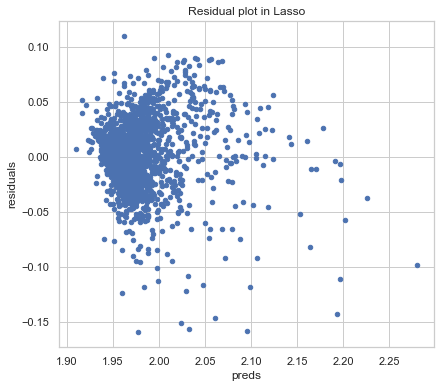

In [ ]:
mpl.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":la.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Lasso")

## Bayesian Regression

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(X_train,y_train)
y1_reg=reg.predict(X_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(X_test)
y2_reg=list(y2_reg)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_reg[i]-y_Train[i])/y_Train[i])
train_error_bay=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_bay)+" percent"+" in Bayesian Regression")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_reg[i]-Y_test[i])/Y_test[i])
test_error_bay=(error/len(Y_test))*100
print("Test error = "+'{}'.format(test_error_bay)+" percent"+" in Bayesian Regression")

Train error = 0.6607076818631121 percent in Bayesian Regression
Test error = 0.0035460495112202934 percent in Bayesian Regression


In [ ]:
names.append("Baynesian Regression")
R2.append(PrintR2(reg,X_test,y_test))
MSE.append(PrintMSE(reg,X_test,y_test))
RMSE.append(PrintRMSE(reg,X_test,y_test))
accuracy.append(PrintAccuracy(reg,X_test,y_test))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Bayesian Regression')

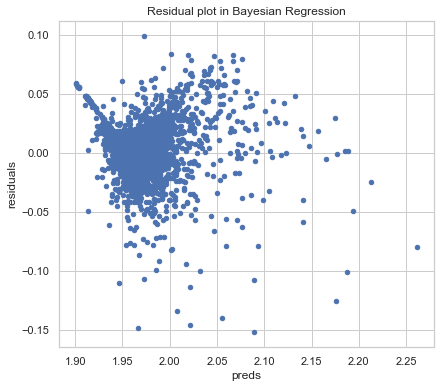

In [ ]:
mpl.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":reg.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

## Decision Tree Regressor

In [ ]:
from sklearn import tree
dec = tree.DecisionTreeRegressor(max_depth=1)
dec.fit(X_train,y_train)
y1_dec=dec.predict(X_train)
y1_dec=list(y1_dec)
y2_dec=dec.predict(X_test)
y2_dec=list(y2_dec)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_dec[i]-y_Train[i])/y_Train[i])
train_error_tree=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_tree)+" percent"+" in Decision Tree Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y1_dec[i]-Y_test[i])/Y_test[i])
test_error_tree=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_tree)+" percent in Decision Tree Regressor")

Train error = 0.824793759462172 percent in Decision Tree Regressor
Test error = 1.348919011356218 percent in Decision Tree Regressor


In [ ]:
names.append("Decision Tree Regressor")
R2.append(PrintR2(dec,X_test,y_test))
MSE.append(PrintMSE(dec,X_test,y_test))
RMSE.append(PrintRMSE(dec,X_test,y_test))
accuracy.append(PrintAccuracy(dec,X_test,y_test))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Decision Tree')

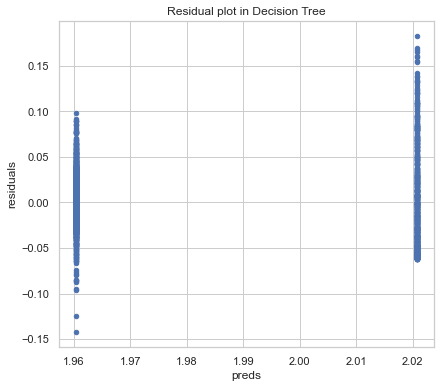

In [ ]:
mpl.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":dec.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Decision Tree")

## Support Vector Machine
-The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

In [ ]:
from sklearn import svm

svm_reg=svm.SVR()
svm_reg.fit(X_train,y_train)
y1_svm=svm_reg.predict(X_train)
y1_svm=list(y1_svm)
y2_svm=svm_reg.predict(X_test)
y2_svm=list(y2_svm)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_svm[i]-y_Train[i])/y_Train[i])
train_error_svm=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_svm)+" percent"+" in SVM Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_svm[i]-Y_test[i])/Y_test[i])
test_error_svm=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_svm)+" percent in SVM Regressor")

Train error = 2.817547275917277 percent in SVM Regressor
Test error = 2.621112492136815 percent in SVM Regressor


In [ ]:
names.append("SVM")
R2.append(PrintR2(svm_reg,X_test,y_test))
MSE.append(PrintMSE(svm_reg,X_test,y_test))
RMSE.append(PrintRMSE(svm_reg,X_test,y_test))
accuracy.append(PrintAccuracy(svm_reg,X_test,y_test))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in SVM')

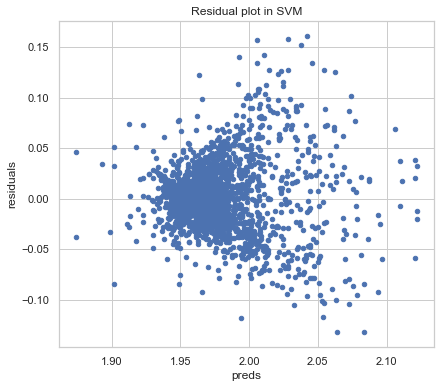

In [ ]:
mpl.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in SVM")

**Train and Test Error**

In [ ]:
train_error=[train_error_ridge,train_error_knn,train_error_lasso,train_error_bay,train_error_tree,train_error_svm]
test_error=[test_error_ridge, test_error_knn,test_error_lasso,test_error_bay,test_error_tree,test_error_svm]

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression', 'Knn', 'Lasso Regression' , 'Bayesian Regression','Decision Tree','SVM']
df=pd.DataFrame(data=col,index=models)
df

,Train Error,Test Error
Ridge Regression,0.661051,0.726277
Knn,0.758625,0.973755
Lasso Regression,0.661051,0.726277
Bayesian Regression,0.660708,0.003546
Decision Tree,0.824794,1.348919
SVM,2.817547,2.621112


**Accuracy Score**

It is an evaluation metric that measures the number of correct predictions made by a model in relation to the total number of predictions made. 

In [ ]:
scores_df = pd.DataFrame(zip(names,accuracy,MSE, RMSE, R2), columns=['Classifier', 'Accuracy Score', 'MSE', 'RMSE','R2'])
print(scores_df)

                Classifier  Accuracy Score       MSE      RMSE        R2
0         Ridge Regression        0.677164  0.000488  0.022099  0.677164
1           Knn Regression        0.050013  0.001437  0.037909  0.050013
2         Lasso Regression        0.583992  0.000629  0.025086  0.583992
3     Baynesian Regression        0.676845  0.000489  0.022110  0.676845
4  Decision Tree Regressor        0.435243  0.000854  0.029229  0.435243
5                      SVM       -1.455049  0.003714  0.060942 -1.455049


Bayesian Regression seems more suitable because it has slightly lower train error, 0.66 and test error almost equals to zero. 